In [31]:
import gensim.models as w2v
import sklearn.decomposition as dcmp
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
import re
import nltk
import sys

Loading model ...
Ready
get_non_compositional_entity_vector:  ['sông']
word:  sông
get_non_compositional_entity_vector:  ['hồ']
word:  hồ
get_non_compositional_entity_vector:  ['núi']
word:  núi
get_non_compositional_entity_vector:  ['biển']
word:  biển
get_non_compositional_entity_vector:  ['trâu']
word:  trâu
get_non_compositional_entity_vector:  ['bò']
word:  bò
get_non_compositional_entity_vector:  ['gà']
word:  gà
get_non_compositional_entity_vector:  ['chó']
word:  chó
get_non_compositional_entity_vector:  ['mèo']
word:  mèo
get_non_compositional_entity_vector:  ['heo']
word:  heo
get_non_compositional_entity_vector:  ['vịt']
word:  vịt
get_non_compositional_entity_vector:  ['Mặt_Trời']
word:  Mặt_Trời
Out-of-vocabulary entity
Not valid Mặt_Trời: "Key 'Mặt_Trời' not present"
get_non_compositional_entity_vector:  ['Trái_Đất']
word:  Trái_Đất
Out-of-vocabulary entity
Not valid Trái_Đất: "Key 'Trái_Đất' not present"
get_non_compositional_entity_vector:  ['vì_sao']
word:  vì_sao
get_

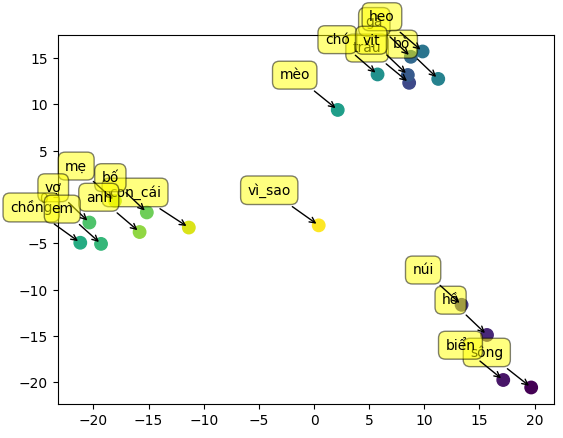

get_non_compositional_entity_vector:  ['vua']
word:  vua
get_non_compositional_entity_vector:  ['chúa']
word:  chúa
get_non_compositional_entity_vector:  ['ca_sĩ']
word:  ca_sĩ
get_non_compositional_entity_vector:  ['diễn_viên']
word:  diễn_viên


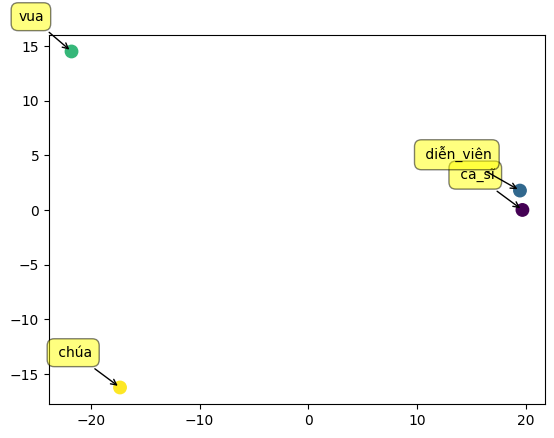

All the terms have been filtered.
Not valid : No valid terms found after processing.


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [32]:
__author__ = "Aubry Cholleton"

path_model_w2v = './baomoi.model.bin'


class SemanticMap:
    def __init__(self, model_path):
        print('Loading model ...')
        self.model = w2v.KeyedVectors.load_word2vec_format(model_path, binary=True, encoding='utf-8')
        print('Ready')

    def __split_words(self, input_string):
        return re.findall(r"[\w']+", input_string)

    def __clean_words(self, words):
        return [w for w in words]

    def __remove_stop_words(self, words):
        # Replace with actual stop word removal logic if needed
        return words

    def __get_non_compositional_entity_vector(self, entity):
        print('get_non_compositional_entity_vector: ', entity)
        word = entity[0]
        print('word: ', word)
        return self.model[word]

    def __get_compositional_entity_vector(self, entity):
        array = np.array(self.model[entity[0]])
        for ind in range(1, len(entity)):
            array += np.array(self.model[entity[ind]])
        return array / len(entity)

    def __get_vector(self, term):
        words = self.__remove_stop_words(self.__clean_words(self.__split_words(term)))

        if len(words) < 1:
            print('All the terms have been filtered.')
            raise ValueError("No valid terms found after processing.")
        if len(words) == 1:
            try:
                return self.__get_non_compositional_entity_vector(words)
            except KeyError:
                print('Out-of-vocabulary entity')
                raise
        elif len(words) < 4:
            try:
                return self.__get_compositional_entity_vector(words)
            except KeyError:
                print('Out-of-vocabulary word in compositional entity')
                raise
        else:
            print('Entity is too long.')
            raise ValueError("Entity too long.")

    def __reduce_dimensionality(self, word_vectors, dimension=2):
        data = np.array(word_vectors)
        pca = dcmp.PCA(n_components=dimension)
        return pca.fit_transform(data)

    def cluster_results(self, data, threshold=0.13):
        return hcluster.fclusterdata(data, threshold, criterion="distance")

    def map_words(self, words, sizes):
        final_words = []
        final_sizes = []
        vectors = []

        for word in words:
            try:
                vect = self.__get_vector(word)
                vectors.append(vect)
                if sizes is not None:
                    final_sizes.append(sizes[words.index(word)])
                final_words.append(word)
            except Exception as e:
                print(f'Not valid {word}: {e}')

        return vectors, final_words, final_sizes

    def plot(self, vectors, lemmas, clusters, sizes=80):
        if not sizes:
            sizes = 80
        plt.scatter(vectors[:, 0], vectors[:, 1], s=sizes, c=clusters)
        for label, x, y in zip(lemmas, vectors[:, 0], vectors[:, 1]):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.show()

    def map_cluster_plot(self, words, sizes, threshold):
        vectors, words, sizes = self.map_words(words, sizes)
        vectors = self.__reduce_dimensionality(vectors)
        clusters = self.cluster_results(vectors, threshold)
        self.plot(vectors, words, clusters, sizes)

    def print_results(self, words, clusters):
        print(words)
        print(clusters.tolist())


def cli(mapper_cli):
    while True:
        encoding = 'utf-8' if sys.stdin.encoding in (None, 'ascii') else sys.stdin.encoding
        line = input('Enter words or MWEs > ')
        if line == 'exit':
            break
        mapper_cli.map_cluster_plot(line.split(','), None, 0.2)


if __name__ == "__main__":
    mapper = SemanticMap(path_model_w2v)
    cli(mapper)